# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Friends Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Friends script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **30 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [70]:
!pip install nltk

In [71]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [72]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

In [73]:
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them. Incorporates dialogue context and scene features.

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}

    # Group dataframe by Scene
    grouped_by_scene = df.groupby('Scene')

    for line, name, gender, scene in zip(df.Line, df.Character_name, df.Gender, df.Scene):
        # Remove empty lines
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue

        # Initialize character_docs entry if not exists
        if name not in character_docs:
            character_docs[name] = ""
            character_line_count[name] = 0

        # Check if the line is from the same scene and add to the character's document
        if scene in grouped_by_scene.groups:
            scene_lines = grouped_by_scene.get_group(scene).Line.tolist()

            # Add lines before and after the target character's line as context
            context_lines = []
            line_index = scene_lines.index(line)

            # Add lines before the target character's line
            context_lines.extend(scene_lines[max(0, line_index - 2):line_index])

            # Add the target character's line
            context_lines.append(line)

            # Add lines after the target character's line
            context_lines.extend(scene_lines[line_index + 1:min(line_index + 3, len(scene_lines))])

            # Join context lines and add an end-of-line token
            character_docs[name] += " ".join(map(str, context_lines)) + " _EOL_ "
            character_line_count[name] += 1

        # Check if the maximum line count is reached for the character
        if character_line_count[name] == max_line_count:
            continue

    print("lines per character", character_line_count)
    return character_docs

In [74]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'Monica Geller': 7538, 'Joey Tribbiani': 7141, 'Chandler Bing': 7607, 'Phoebe Buffay': 6550, '#ALL#': 318, 'Ross Geller': 7884, 'Rachel Green': 8063, 'Other_None': 4372, 'Other_Female': 1722, 'Other_Male': 2329}
Num. Characters:  10 

Monica Geller Number of Words:  388514
Joey Tribbiani Number of Words:  367577
Chandler Bing Number of Words:  397959
Phoebe Buffay Number of Words:  343496
#ALL# Number of Words:  13321
Ross Geller Number of Words:  406144
Rachel Green Number of Words:  419955
Other_None Number of Words:  215059
Other_Female Number of Words:  89132
Other_Male Number of Words:  118953
total words 2760110


In [75]:
!pip install contractions

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 30 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **10**. Initially, the code in this template achieves a mean rank of **4.0**  and accuracy of **0.3** on the test set and a mean rank of **4.2** and accuracy of **0.1** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [76]:
import nltk
from nltk.corpus import stopwords
from sklearn.impute import SimpleImputer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup  # Import BeautifulSoup
import contractions  # Import contractions library
import re

train_data['Line'].fillna("", inplace=True)

nltk.download('stopwords')

def pre_process(character_text):
    """Enhanced pre-processing for character text.

    ::character_text:: a string with all of one character's lines
    """
    # Lowercasing
    character_text = character_text.lower()

    # Expand contractions
    character_text = contractions.fix(character_text)

    # Remove special characters, symbols, and numbers
    character_text = re.sub(r'[^a-zA-Z\s]', '', character_text)

    # Remove short words (length < 3)
    character_text = ' '.join([word for word in character_text.split() if len(word) > 2])

    # Remove single characters
    character_text = ' '.join([word for word in character_text.split() if len(word) > 1])

    # Tokenization
    tokens = nltk.word_tokenize(character_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html.

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

In [78]:
'''Tfidf Technique'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from collections import Counter
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


def to_feature_vector_dictionary(character_doc, extra_features):
    """Enhanced feature extraction for a list of pre-processed tokens and extra features.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to the feature vector dict
    """
    # Word frequency count
    counts = Counter(character_doc)

    # Add the extra features
    for feature in extra_features:
        if feature == 'ngrams':
            # Include n-grams of different lengths
            ngrams = Counter(nltk.ngrams(character_doc, 2))  # Change 2 to other values for different n-grams
            counts.update(ngrams)

        elif feature == 'pos_tags':
            # Include POS tags
            pos_tags = nltk.pos_tag(character_doc)
            pos_counts = Counter(tag for word, tag in pos_tags)
            counts.update(pos_counts)

        elif feature == 'tfidf':
            # Include TF-IDF scores
            tfidf_vectorizer = TfidfVectorizer()
            tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(character_doc)])
            tfidf_scores = {word: score for word, score in zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.toarray()[0])}
            counts.update(tfidf_scores)

        elif feature == 'sentiment':
            # Include sentiment analysis score
            sentiment_analyzer = SentimentIntensityAnalyzer()
            sentiment_score = sentiment_analyzer.polarity_scores(' '.join(character_doc))['compound']
            counts['sentiment'] = sentiment_score


    return counts

corpusVectorizer = DictVectorizer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Enhanced method for fitting different vectorizers on data and returning a matrix.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    if fitting:
        # Use TF-IDF vectorizer
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])


    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [79]:
training_feature_matrix

<10x12397 sparse matrix of type '<class 'numpy.float64'>'
	with 60608 stored elements in Compressed Sparse Row format>

In [81]:
import nltk
nltk.download('punkt')

# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


lines per character {'Other_None': 275, 'Rachel Green': 589, 'Other_Male': 171, 'Ross Geller': 571, '#ALL#': 18, 'Phoebe Buffay': 504, 'Chandler Bing': 591, 'Monica Geller': 525, 'Joey Tribbiani': 627, 'Other_Female': 87}
Num. Characters:  10 

Other_None Num of Words:  14025
Rachel Green Num of Words:  31285
Other_Male Num of Words:  8910
Ross Geller Num of Words:  30172
#ALL# Num of Words:  802
Phoebe Buffay Num of Words:  27510
Chandler Bing Num of Words:  32264
Monica Geller Num of Words:  26985
Joey Tribbiani Num of Words:  34092
Other_Female Num of Words:  4617
total words 210662


In [82]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [83]:
val_feature_matrix

<10x12397 sparse matrix of type '<class 'numpy.float64'>'
	with 11552 stored elements in Compressed Sparse Row format>

In [84]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [85]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])

    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Replace NaN values in 'Line' column with an empty string
#train_data['Line'].fillna("", inplace=True)

# Other parts of your code remain the same
param_grid_tfidf = {
    'tfidf__max_features': [500, 1000, 2000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

# Example grid search for TF-IDF vectorizer
param_grid_tfidf = {
    'tfidf__max_features': [500, 1000, 2000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

tfidf_vectorizer = TfidfVectorizer()
pipeline_tfidf = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('ch2', SelectKBest(chi2)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid=param_grid_tfidf, scoring='accuracy', cv=5)
grid_search_tfidf.fit(train_data['Line'], train_data['Character_name'])
best_tfidf_params = grid_search_tfidf.best_params_

# Use best parameters in the final model
tfidf_vectorizer = TfidfVectorizer(max_features=best_tfidf_params['tfidf__max_features'], ngram_range=best_tfidf_params['tfidf__ngram_range'])

# Create a new pipeline with the classifier
final_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('ch2', SelectKBest(chi2)), # feature selection using k best
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Use Random Forest as an example
])

# Train the final model on the entire training set
final_pipeline.fit(train_data['Line'], train_data['Character_name'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=500, ngram_range=(1, 2))),
                ('ch2',
                 SelectKBest(score_func=<function chi2 at 0x7934be7d6b90>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [87]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

Based on the heatmap provided, we can observe the similarities between character vectors from the training set and those in the heldout (validation) set. Here are some potential insights and reasons why certain characters might be closest or furthest away in terms of vector similarity:

**Closest Vectors Not Being Themselves:**
- **Similar Language Use:** Characters that interact frequently or share similar roles in the narrative might use similar language, phrases, or responses. This can result in similar word or n-gram features.
- **Shared Themes or Topics:** Characters that discuss similar topics or are involved in similar storylines might have dialogue that is thematically similar, leading to closer vector proximity.
- **Background or Personality:** Characters with similar backgrounds or personality traits might express themselves in similar ways, influencing their linguistic patterns.

For example, if Joey and Chandler have high similarity scores, it might be due to their frequent interactions and shared storylines, which would lead to them using similar language and expressions.

**Furthest Vectors:**
- **Distinct Language Use:** Characters with unique or distinct ways of speaking, perhaps due to profession, education, or personality, might have dialogue that is quite different from others, leading to a larger distance between vectors.
- **Different Themes or Topics:** If a character often discusses topics that are not commonly addressed by others, this can result in a feature vector that is quite distinct from others.
- **Less Interaction:** Characters who interact less with the main cast or have fewer lines might not have enough common language to result in a high similarity score.

For example, if Ross and "Other_Male" have a low similarity score, it might be because "Other_Male" represents a variety of side characters who do not share Ross's interests or manner of speaking, leading to a less similar word distribution in their dialogue.

In cases where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set, consider:
- **Insufficient Data:** There may not be enough data to accurately capture a character's linguistic profile, especially if they have fewer lines or are less prominent in the dataset.
- **Anomaly in Dialogues:** A particular character's dialogue in the heldout set might be atypical compared to their usual dialogue patterns in the training set, perhaps due to an unusual storyline or situation.

When writing your report, you would dive deeper into the specific language patterns, n-gram frequencies, and other linguistic features that might explain these observations. Analyzing the dialogue content for thematic elements and character interactions can provide a more nuanced understanding of the similarities and differences indicated by the heatma

# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

mean rank 2.0
mean cosine similarity 0.9448064943880624
8 correct out of 10 / accuracy: 0.8
Closest Vectors:
[('#ALL#', 'Joey Tribbiani'), ('Chandler Bing', 'Monica Geller'), ('Joey Tribbiani', 'Chandler Bing'), ('Monica Geller', 'Chandler Bing'), ('Other_Female', 'Other_None'), ('Other_Male', 'Monica Geller'), ('Other_None', 'Other_Male'), ('Phoebe Buffay', 'Rachel Green'), ('Rachel Green', 'Ross Geller'), ('Ross Geller', 'Rachel Green')]

Furthest Vectors:
[('#ALL#', 'Other_Male'), ('Chandler Bing', '#ALL#'), ('Joey Tribbiani', '#ALL#'), ('Monica Geller', '#ALL#'), ('Other_Female', '#ALL#'), ('Other_Male', '#ALL#'), ('Other_None', '#ALL#'), ('Phoebe Buffay', '#ALL#'), ('Rachel Green', '#ALL#'), ('Ross Geller', '#ALL#')]


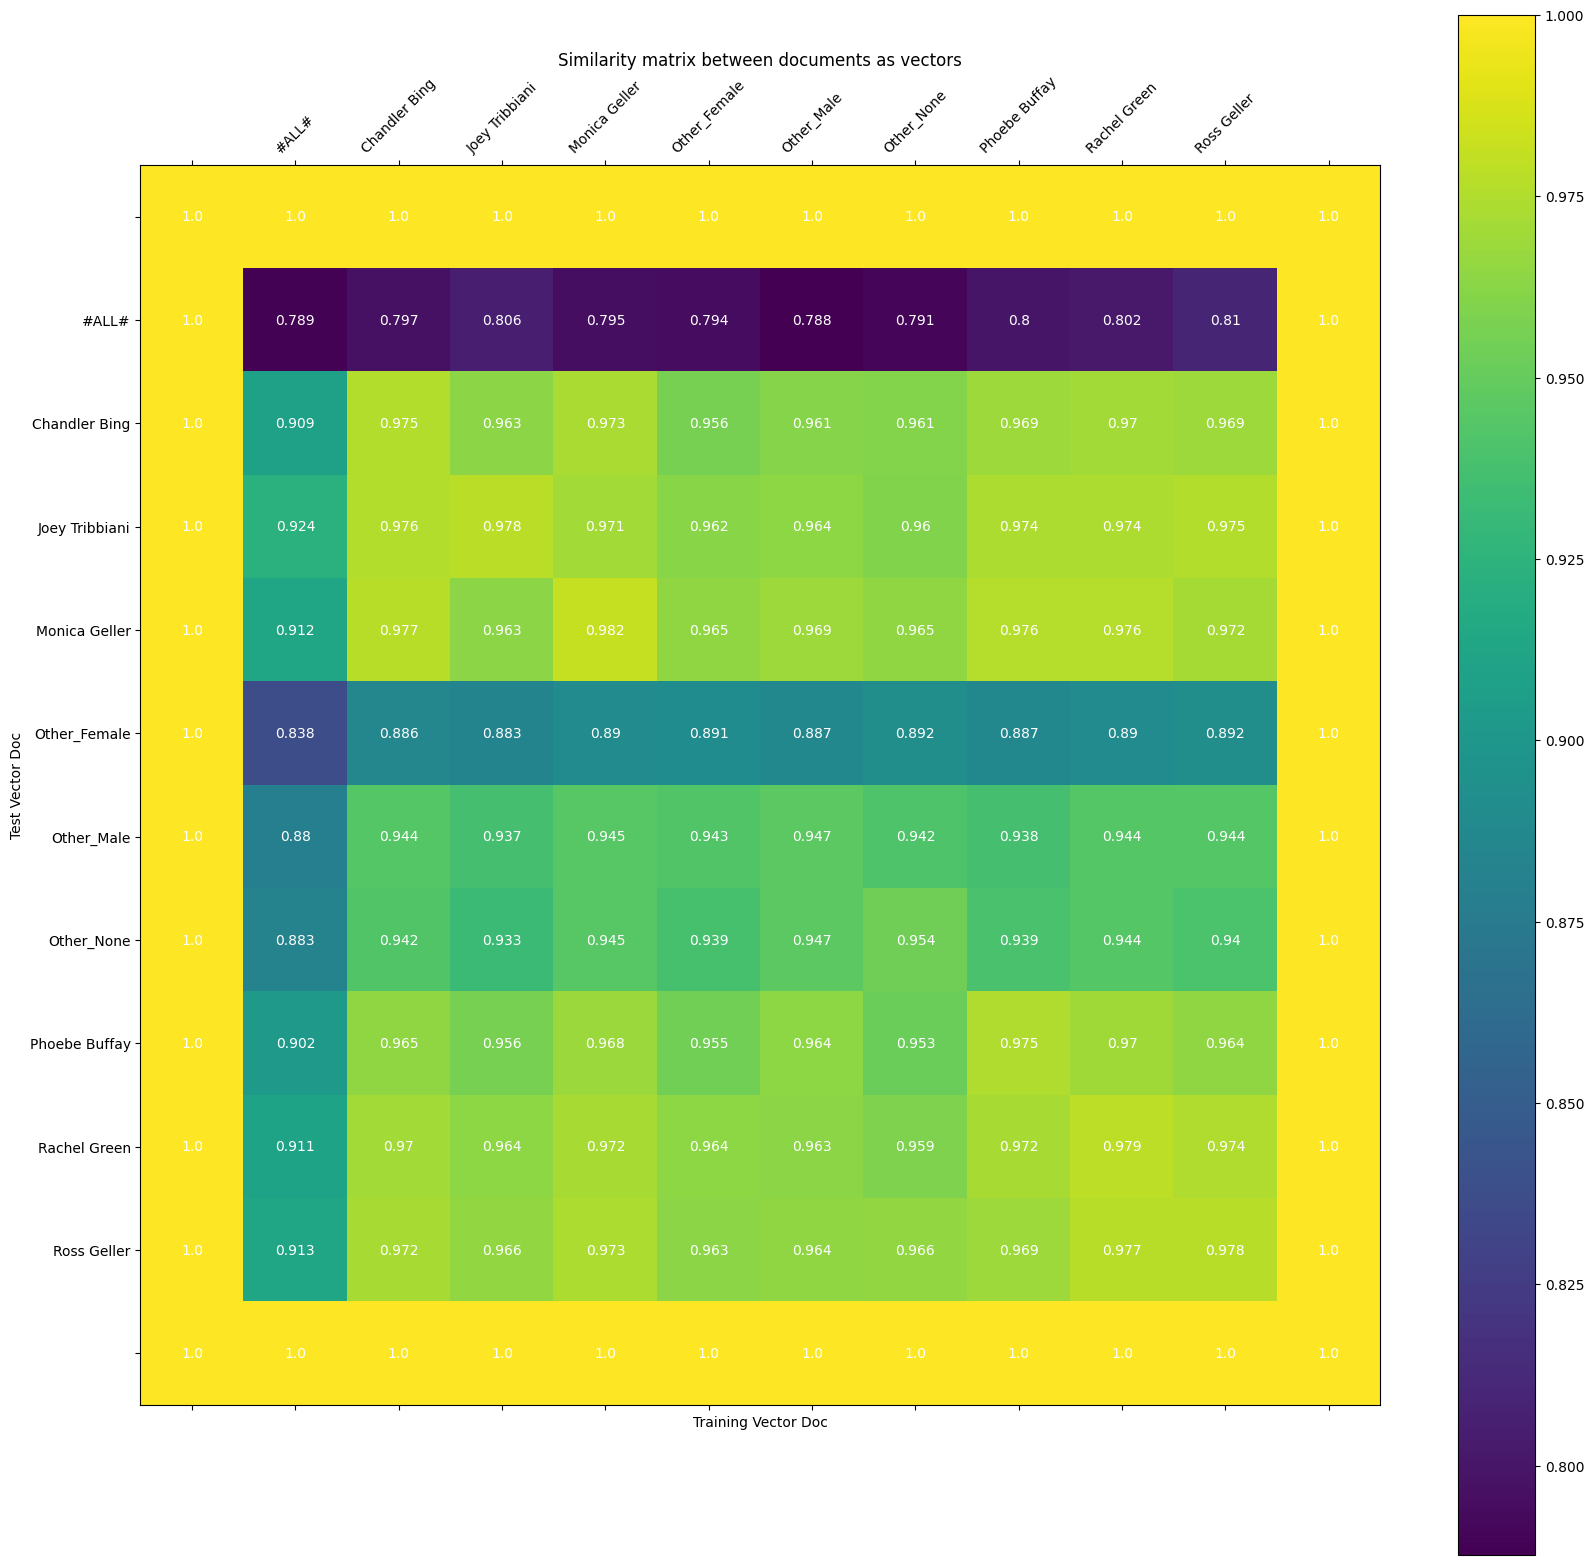

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define a function to find closest and furthest vectors for each training character
def find_closest_and_furthest_vectors(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    closest_vectors = []
    furthest_vectors = []

    # Rank heldout vectors based on similarity for each training character
    for train_char in train_labels:
        char_df = df[df['doc1'] == train_char]
        ranked_df = char_df.sort_values(by='similarity', ascending=False)

        # Extract closest and furthest vectors
        closest_vector = ranked_df.iloc[1]['doc2']  # Skip the first row as it's the same character
        furthest_vector = ranked_df.iloc[-1]['doc2']

        closest_vectors.append((train_char, closest_vector))
        furthest_vectors.append((train_char, furthest_vector))

    return closest_vectors, furthest_vectors

# Step 1: Compute IR evaluation scores
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

# Step 2: Find closest and furthest vectors
closest_vectors, furthest_vectors = find_closest_and_furthest_vectors(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

# Step 3: Print closest and furthest vectors
print("Closest Vectors:")
print(closest_vectors)
print("\nFurthest Vectors:")
print(furthest_vectors)

# Step 4: Plot heatmap
plot_heat_map_similarity(df)

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 30 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [90]:
# Redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ', len(train_character_docs.keys()), "\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ', len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# Get the test data using 30 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
print('Num. Characters: ', len(test_character_docs.keys()), "\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ', len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# Create a list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]

# Use the same vectorizer and other transformers as in training
# Only transform the test data, don't fit again
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)

# Evaluate on the test data
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)
print("Test Mean Rank:", mean_rank)
print("Test Mean Cosine Similarity:", mean_cosine_similarity)
print("Test Accuracy:", acc)

lines per character {'Monica Geller': 7538, 'Joey Tribbiani': 7141, 'Chandler Bing': 7607, 'Phoebe Buffay': 6550, '#ALL#': 318, 'Ross Geller': 7884, 'Rachel Green': 8063, 'Other_None': 4372, 'Other_Female': 1722, 'Other_Male': 2329}
Num. Characters:  10 

Monica Geller Number of Words:  388506
Joey Tribbiani Number of Words:  367563
Chandler Bing Number of Words:  397951
Phoebe Buffay Number of Words:  343468
#ALL# Number of Words:  13321
Ross Geller Number of Words:  406133
Rachel Green Number of Words:  419937
Other_None Number of Words:  215052
Other_Female Number of Words:  89128
Other_Male Number of Words:  118949
total words 2760008
lines per character {'Ross Geller': 705, 'Joey Tribbiani': 440, 'Chandler Bing': 370, 'Other_Female': 190, 'Other_None': 317, '#ALL#': 11, 'Monica Geller': 434, 'Rachel Green': 676, 'Phoebe Buffay': 482, 'Other_Male': 201}
Num. Characters:  10 

Ross Geller Number of Words:  35746
Joey Tribbiani Number of Words:  23803
Chandler Bing Number of Words:  